<a href="https://colab.research.google.com/github/suyashmarathe512/suyash/blob/main/Web_Scrapper_of_CPQ_Apps_from_appExchange.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# OCR engine
get_ipython().system('sudo apt-get update')
get_ipython().system('sudo apt-get install -y tesseract-ocr')

# Python packages
get_ipython().system('pip install pytesseract pillow pandas')
get_ipython().system('pip install playwright')
get_ipython().system('playwright install')
get_ipython().system('sudo apt-get install -y libxcomposite1 libgtk-3-0 libatk1.0-0')

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://cli.github.com/packages stable InRelease [3,917 B]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [6,087 kB]
Get:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [83.6 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,576 kB]
Hit:13 https://ppa.launchpadcontent.net/ubu

In [ ]:
import asyncio
import re
from collections import Counter
from pathlib import Path

import pandas as pd
import pytesseract
from PIL import Image
from playwright.async_api import async_playwright, TimeoutError as PlaywrightTimeoutError

# ---------------------------------------------------
# Optional: set tesseract path (Windows, if needed)
# ---------------------------------------------------
# Example (adjust based on your installation):
# pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"


# -----------------------------
# CPQ Apps (as provided)
# -----------------------------

CPQ_APPS = {
  "PandaDoc": "a0N3A00000DvMrEUAV"
}

APPEX_BASE_URL = "https://appexchange.salesforce.com/appxListingDetail"

# Tabs we care about: default (no tab param), &tab=e, &tab=d
TABS = [
    ("default", None),
    ("e", "e"),
    ("d", "d"),
]

STOPWORDS = {
    "the", "and", "for", "with", "you", "your", "are", "was", "were",
    "this", "that", "but", "from", "have", "has", "had", "will", "would",
    "should", "could", "they", "them", "their", "our", "ours", "about",
    "into", "onto", "over", "under", "such", "also", "only", "than",
    "then", "there", "here", "when", "where", "which", "while", "whose",
    "can", "cannot", "cant", "dont", "doesnt", "didnt", "isnt", "arent",
    "wasnt", "werent", "its", "been", "being", "may", "might",
    "must", "shall", "very", "more", "most", "some", "any", "all",
    "each", "every", "other", "another", "few", "many",
    "in", "on", "at", "by", "to", "of", "as", "or", "an", "a", "it",
}


# -----------------------------
# Helpers
# -----------------------------

def slugify(name: str) -> str:
    """Safe filename from name."""
    s = re.sub(r"[^a-zA-Z0-9]+", "_", name.strip())
    s = re.sub(r"_+", "_", s)
    return s.strip("_").lower()


def ocr_image(path: Path) -> str:
    """Run OCR on an image file and return raw text."""
    img = Image.open(path)
    img = img.convert("L")  # grayscale
    text = pytesseract.image_to_string(img)
    return text.strip()


def compute_tf(text: str, top_n: int = 25):
    """
    Compute TF from text.
    Returns: (tf_df, full_counts)
    tf_df: DataFrame with ['term','tf'] for top_n
    full_counts: Counter of all terms (if you want later)
    """
    tokens = re.findall(r"[a-zA-Z]{3,}", text.lower())
    tokens = [t for t in tokens if t not in STOPWORDS]

    counts = Counter(tokens)
    most_common = counts.most_common(top_n)
    df = pd.DataFrame(most_common, columns=["term", "tf"])
    return df, counts


# -----------------------------
# Playwright listing + tabs
# -----------------------------

async def screenshot_tab(page, listing_id: str, tab_name: str, tab_param: str | None,
                         screenshots_dir: Path) -> Path | None:
    """
    For a given listing & tab, navigate and capture a screenshot.
    Avoids duplication by filename: listingid + tab_name.
    """
    base_slug = slugify(listing_id)
    filename = f"{base_slug}_tab-{tab_name}.png"
    screenshot_path = screenshots_dir / filename

    # If file already exists, don't re-capture (avoid duplicate PNG work)
    if screenshot_path.exists():
        print(f"[INFO] Reusing existing screenshot: {screenshot_path}")
        return screenshot_path

    # Build URL with or without tab param
    if tab_param:
        url = f"{APPEX_BASE_URL}?listingId={listing_id}&tab={tab_param}"
    else:
        url = f"{APPEX_BASE_URL}?listingId={listing_id}"

    print(f"[INFO]   Navigating to tab '{tab_name}' -> {url}")

    try:
        response = await page.goto(url, wait_until="networkidle", timeout=60000)
    except TimeoutError as e:
        print(f"[WARN]   networkidle timeout on {url}: {e}. Trying domcontentloaded.")
        response = await page.goto(url, wait_until="domcontentloaded", timeout=60000)

    if response is not None:
        try:
            print(f"[INFO]   HTTP status (tab {tab_name}): {response.status}")
        except Exception:
            pass

    await page.wait_for_timeout(2000)

    try:
        await page.screenshot(path=str(screenshot_path), full_page=True)
        print(f"[INFO]   Saved screenshot: {screenshot_path}")
        return screenshot_path
    except Exception as e:
        print(f"[ERROR]  Failed to save screenshot for listing {listing_id}, tab {tab_name}: {e}")
        return None


async def process_listing(page, listing_id: str,
                          screenshots_dir: Path, ocr_dir: Path, tf_dir: Path):
    """
    For a single listingId:
      - Visit each tab (default, e, d)
      - Screenshot each (dedup by filename)
      - OCR each screenshot
      - Concatenate all OCR text
      - Compute TF on combined text
      - Save combined OCR and TF for this listing
    Returns: tf_df (or None if failed)
    """
    print(f"\n[INFO] Processing listing: {listing_id}")

    texts = []
    for tab_name, tab_param in TABS:
        screenshot_path = await screenshot_tab(page, listing_id, tab_name, tab_param, screenshots_dir)
        if screenshot_path is None:
            continue

        try:
            text = ocr_image(screenshot_path)
            print(f"[INFO]   OCR len for tab '{tab_name}': {len(text)}")
            texts.append(text)
        except Exception as e:
            print(f"[ERROR]  OCR failed for listing {listing_id}, tab {tab_name}: {e}")

    combined_text = "\n\n".join(t for t in texts if t)
    print(f"[INFO] Combined OCR text length for listing {listing_id}: {len(combined_text)}")

    listing_slug = slugify(listing_id)
    combined_text_path = ocr_dir / f"{listing_slug}_combined_ocr.txt"
    try:
        with open(combined_text_path, "w", encoding="utf-8") as f:
            f.write(combined_text)
        print(f"[INFO] Saved combined OCR text: {combined_text_path}")
    except Exception as e:
        print(f"[WARN] Failed to save combined OCR for listing {listing_id}: {e}")

    if not combined_text or len(combined_text) < 50:
        print(f"[WARN] Combined text too short for listing {listing_id}, skipping TF.")
        return None

    tf_df, _ = compute_tf(combined_text, top_n=25)

    tf_csv_path = tf_dir / f"{listing_slug}_tf.csv"
    try:
        tf_df.to_csv(tf_csv_path, index=False)
        print(f"[INFO] Saved listing TF CSV: {tf_csv_path}")
    except Exception as e:
        print(f"[WARN] Failed to save TF CSV for listing {listing_id}: {e}")

    return tf_df


# -----------------------------
# Batch runner
# -----------------------------

async def run_batch():
    base_dir = Path(".")
    screenshots_dir = base_dir / "screenshots_cpq_tabs"
    ocr_dir = base_dir / "ocr_text_cpq_tabs"
    tf_dir = base_dir / "tf_cpq_tabs"

    for d in [screenshots_dir, ocr_dir, tf_dir]:
        d.mkdir(parents=True, exist_ok=True)

    # Reverse index: listing_id -> list of app_names
    listing_to_apps = {}
    for app_name, listing_id in CPQ_APPS.items():
        listing_to_apps.setdefault(listing_id, []).append(app_name)

    all_rows = []
    listing_tf_cache = {}  # listing_id -> tf_df

    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        page = await browser.new_page()

        # Process each unique listingId once
        for listing_id, app_names in listing_to_apps.items():
            try:
                tf_df = await process_listing(page, listing_id, screenshots_dir, ocr_dir, tf_dir)
                listing_tf_cache[listing_id] = tf_df
            except PlaywrightTimeoutError as e:
                print(f"[FATAL] Timeout for listing {listing_id}: {e}")
                listing_tf_cache[listing_id] = None
            except Exception as e:
                print(f"[FATAL] Unexpected error for listing {listing_id}: {e}")
                listing_tf_cache[listing_id] = None

        await browser.close()

    # Map listing-level TF back to each app_name
    for app_name, listing_id in CPQ_APPS.items():
        tf_df = listing_tf_cache.get(listing_id)
        if tf_df is None or tf_df.empty:
            print(f"[WARN] No TF data for app '{app_name}' (listing {listing_id})")
            continue

        for _, row in tf_df.iterrows():
            all_rows.append({
                "app_name": app_name,
                "listing_id": listing_id,
                "term": row["term"],
                "tf": int(row["tf"]),
            })

    # Combined CSV
    if all_rows:
        df_all = pd.DataFrame(all_rows)
        df_all.to_csv("all_cpq_tf_from_ocr_tabs.csv", index=False)
        print("\n[INFO] Saved combined TF for all apps -> all_cpq_tf_from_ocr_tabs.csv")
    else:
        print("\n[WARN] No TF rows generated. Check logs / OCR / listing IDs.")


await run_batch()


[INFO] Processing listing: a0N3A00000DvMrEUAV
[INFO]   Navigating to tab 'default' -> https://appexchange.salesforce.com/appxListingDetail?listingId=a0N3A00000DvMrEUAV
[INFO]   HTTP status (tab default): 200
[INFO]   Saved screenshot: screenshots_cpq_tabs/a0n3a00000dvmreuav_tab-default.png
[INFO]   OCR len for tab 'default': 4712
[INFO]   Navigating to tab 'e' -> https://appexchange.salesforce.com/appxListingDetail?listingId=a0N3A00000DvMrEUAV&tab=e
[INFO]   HTTP status (tab e): 200
[INFO]   Saved screenshot: screenshots_cpq_tabs/a0n3a00000dvmreuav_tab-e.png
[INFO]   OCR len for tab 'e': 4552
[INFO]   Navigating to tab 'd' -> https://appexchange.salesforce.com/appxListingDetail?listingId=a0N3A00000DvMrEUAV&tab=d
[INFO]   HTTP status (tab d): 200
[INFO]   Saved screenshot: screenshots_cpq_tabs/a0n3a00000dvmreuav_tab-d.png
[INFO]   OCR len for tab 'd': 4777
[INFO] Combined OCR text length for listing a0N3A00000DvMrEUAV: 14045
[INFO] Saved combined OCR text: ocr_text_cpq_tabs/a0n3a00000d

In [ ]:
import pandas as pd

df_all_cpq = pd.read_csv('all_cpq_tf_from_ocr_tabs.csv')

# Remove rows where tf is 1
df_filtered = df_all_cpq[df_all_cpq['tf'] != 1]

# Pivot the DataFrame
df_pivot = df_filtered.pivot_table(index='app_name', columns='term', values='tf', fill_value=0)

# Display the resulting DataFrame
display(df_pivot)

term,automation,available,built,cloud,cpq,create,data,details,document,documents,...,month,pandadoc,payment,pricing,quotes,revenue,sales,salesforce,security,templates
app_name,,,,,,,,,,,,,,,,,,,,,
PandaDoc,11.0,9.0,13.0,19.0,33.0,17.0,14.0,14.0,29.0,12.0,...,13.0,60.0,10.0,11.0,13.0,23.0,13.0,52.0,11.0,12.0


In [ ]:
# Calculate the total frequency of each term across all apps
term_totals = df_filtered.groupby('term')['tf'].sum().sort_values(ascending=False)

# Select the top N terms (e.g., top 15) for better readability
top_n_terms = term_totals.head(15).index.tolist()

# Filter the original DataFrame to include only these top terms
df_top_terms = df_filtered[df_filtered['term'].isin(top_n_terms)]

# Re-pivot the DataFrame with only the top terms
df_pivot_refined = df_top_terms.pivot_table(index='app_name', columns='term', values='tf', fill_value=0)

# Display the refined DataFrame
display(df_pivot_refined.head())

term,built,cloud,cpq,create,data,details,document,integration,month,pandadoc,quotes,revenue,sales,salesforce,templates
app_name,,,,,,,,,,,,,,,
PandaDoc,13.0,19.0,33.0,17.0,14.0,14.0,29.0,12.0,13.0,60.0,13.0,23.0,13.0,52.0,12.0


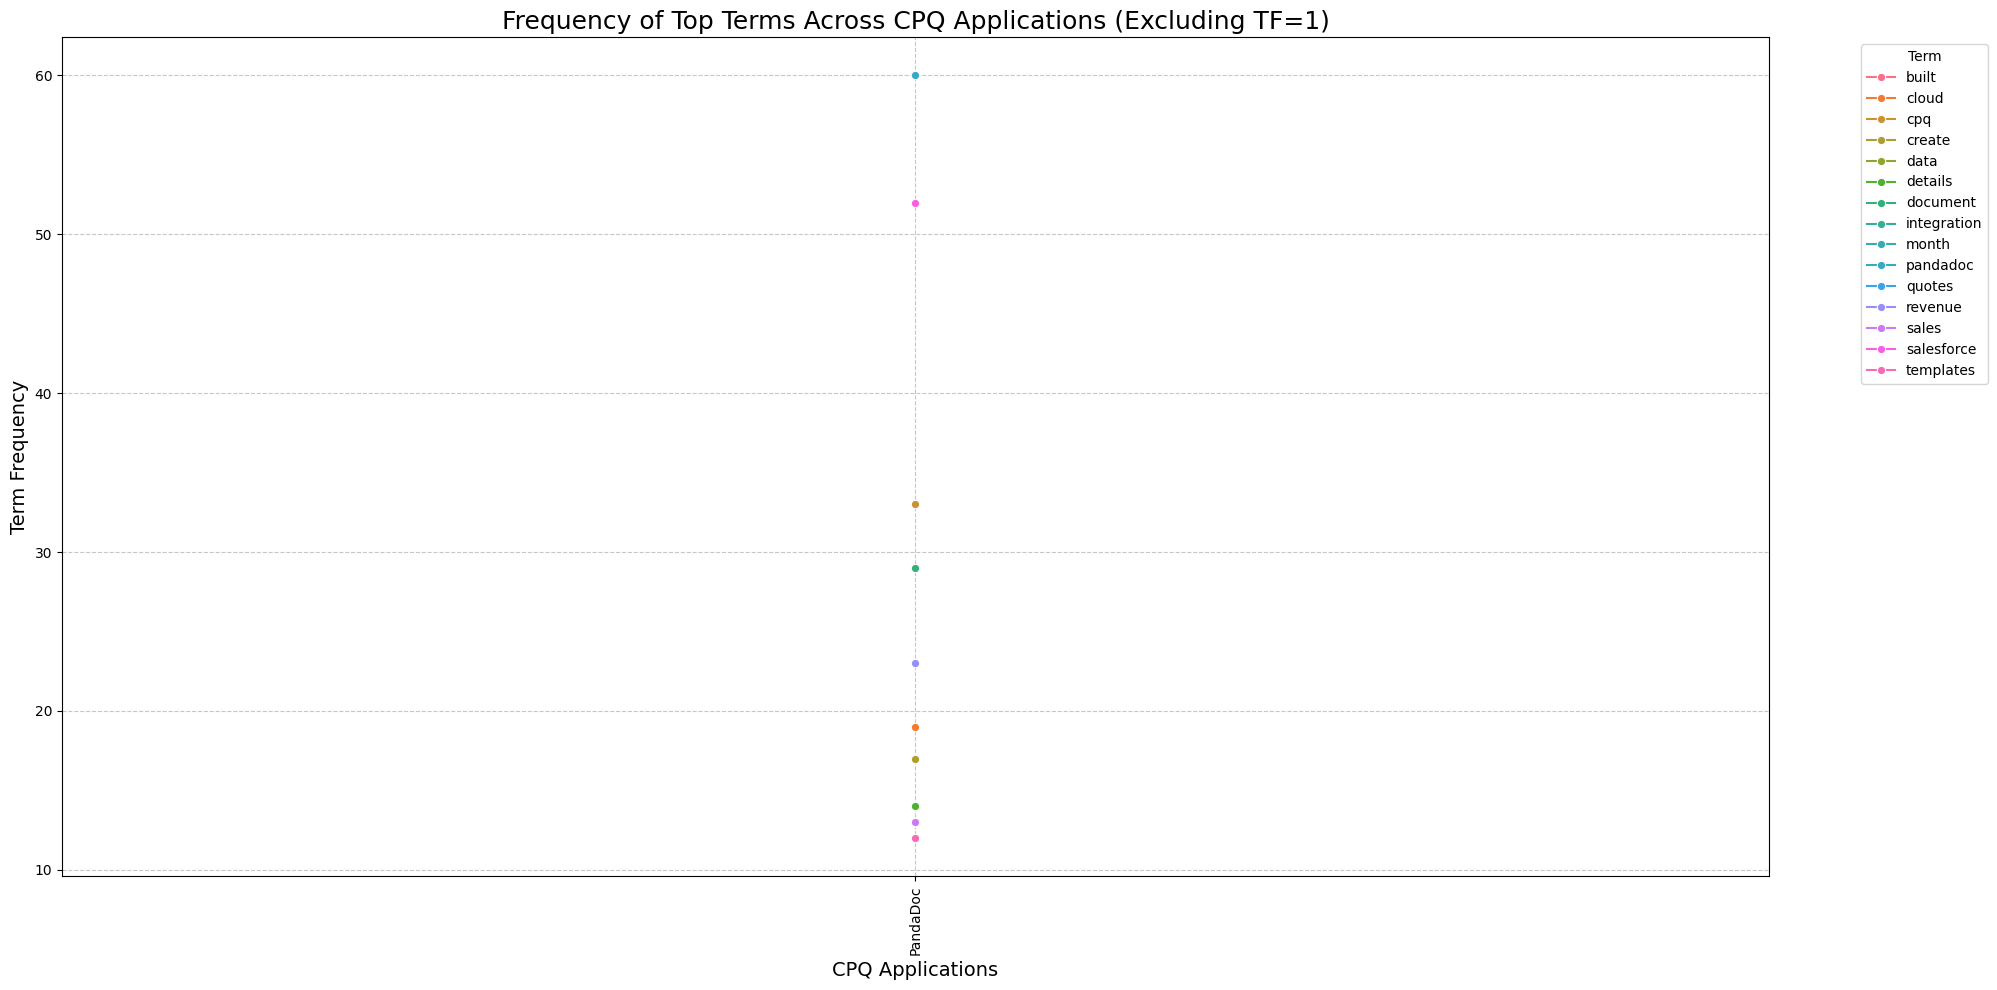

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Melt the df_pivot_refined DataFrame for plotting
# This converts columns (terms) into rows, making it suitable for line plots with 'hue'
df_melted = df_pivot_refined.reset_index().melt(id_vars='app_name', var_name='term', value_name='tf')

# Filter out rows where term frequency is 0, as they don't contribute to a line
df_melted = df_melted[df_melted['tf'] > 0]

# Set a larger figure size for better readability
plt.figure(figsize=(20, 10))

# Create the line plot
# x-axis: CPQ Applications, y-axis: Term Frequency, hue: distinct lines for each term
sns.lineplot(data=df_melted, x='app_name', y='tf', hue='term', marker='o')

plt.title('Frequency of Top Terms Across CPQ Applications (Excluding TF=1)', fontsize=18)
plt.xlabel('CPQ Applications', fontsize=14)
plt.ylabel('Term Frequency', fontsize=14)
plt.xticks(rotation=90) # Rotate x-axis labels to prevent overlap
plt.legend(title='Term', bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend outside the plot area
plt.grid(True, linestyle='--', alpha=0.7) # Add a grid for easier reading of values
plt.tight_layout() # Adjust layout to ensure everything fits
plt.show()

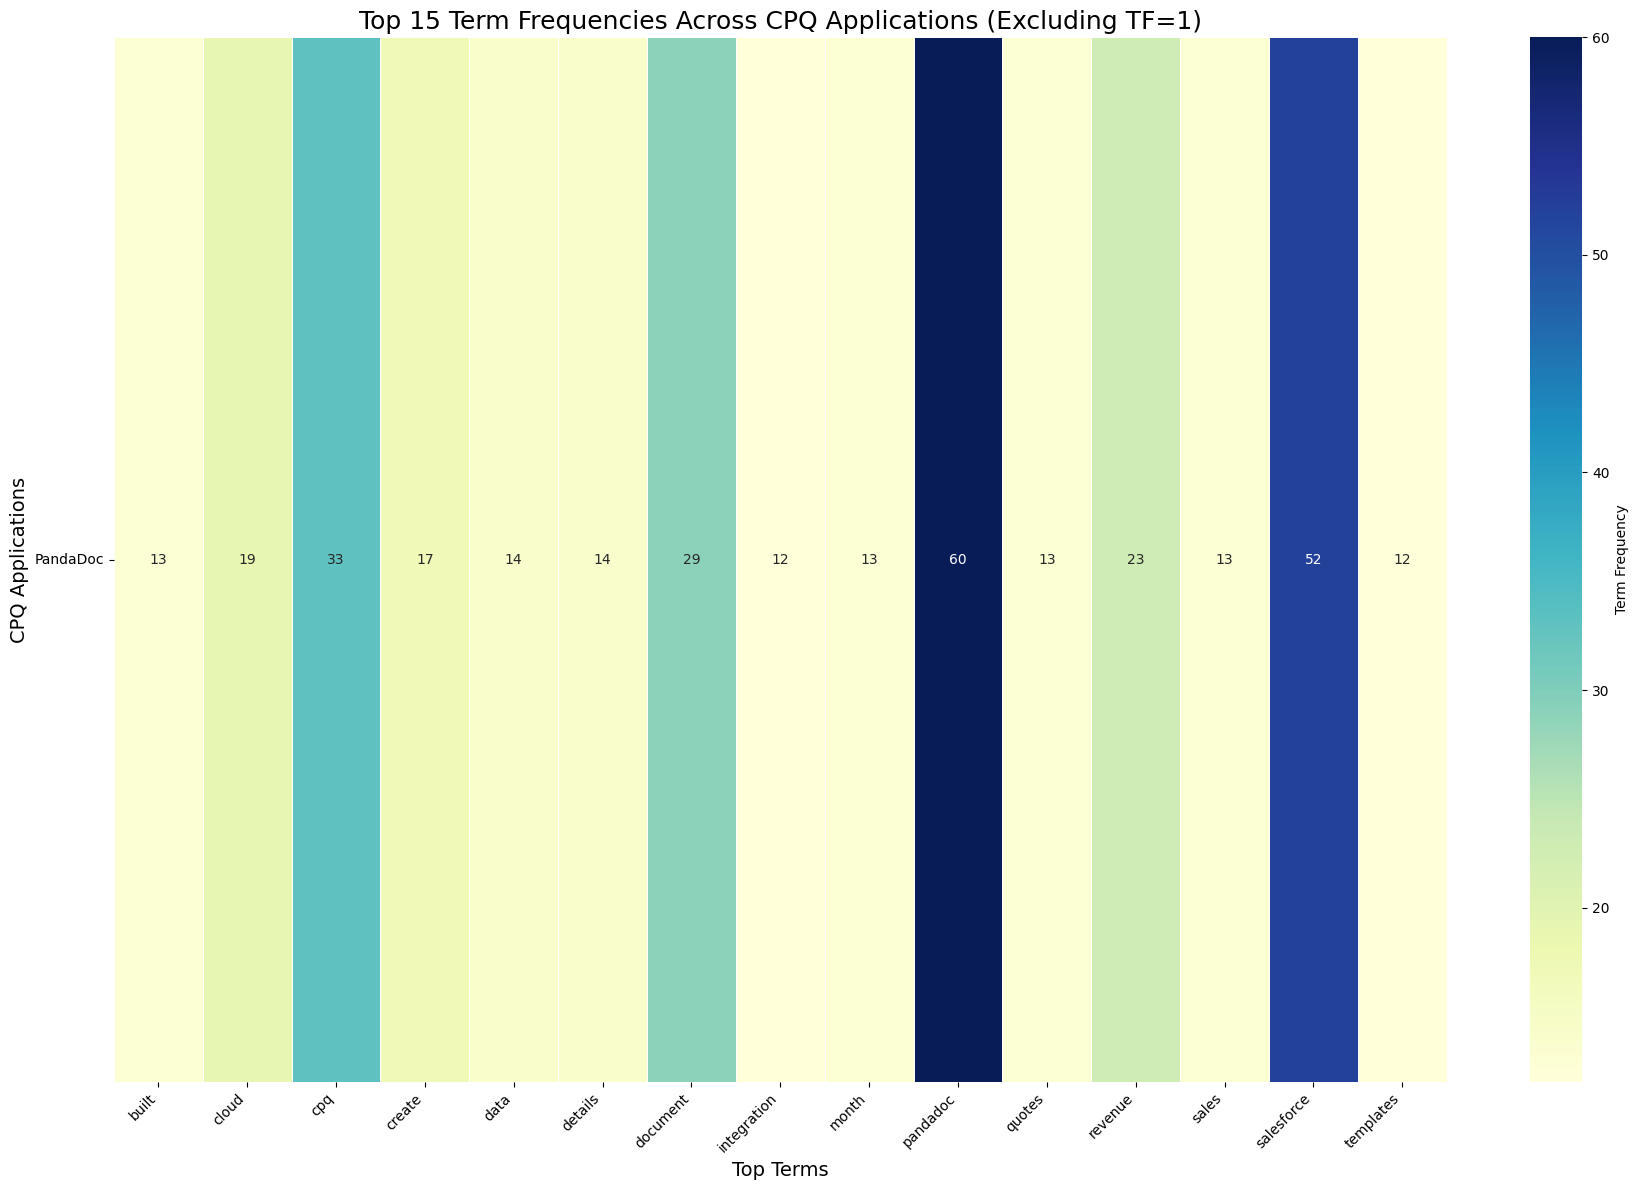

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a larger figure size for better readability
plt.figure(figsize=(18, 12))

# Create a heatmap with the refined data
sns.heatmap(df_pivot_refined, cmap='YlGnBu', annot=True, fmt='.0f', linewidths=.5, cbar_kws={'label': 'Term Frequency'})

plt.title('Top 15 Term Frequencies Across CPQ Applications (Excluding TF=1)', fontsize=18)
plt.xlabel('Top Terms', fontsize=14)
plt.ylabel('CPQ Applications', fontsize=14)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better fit
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

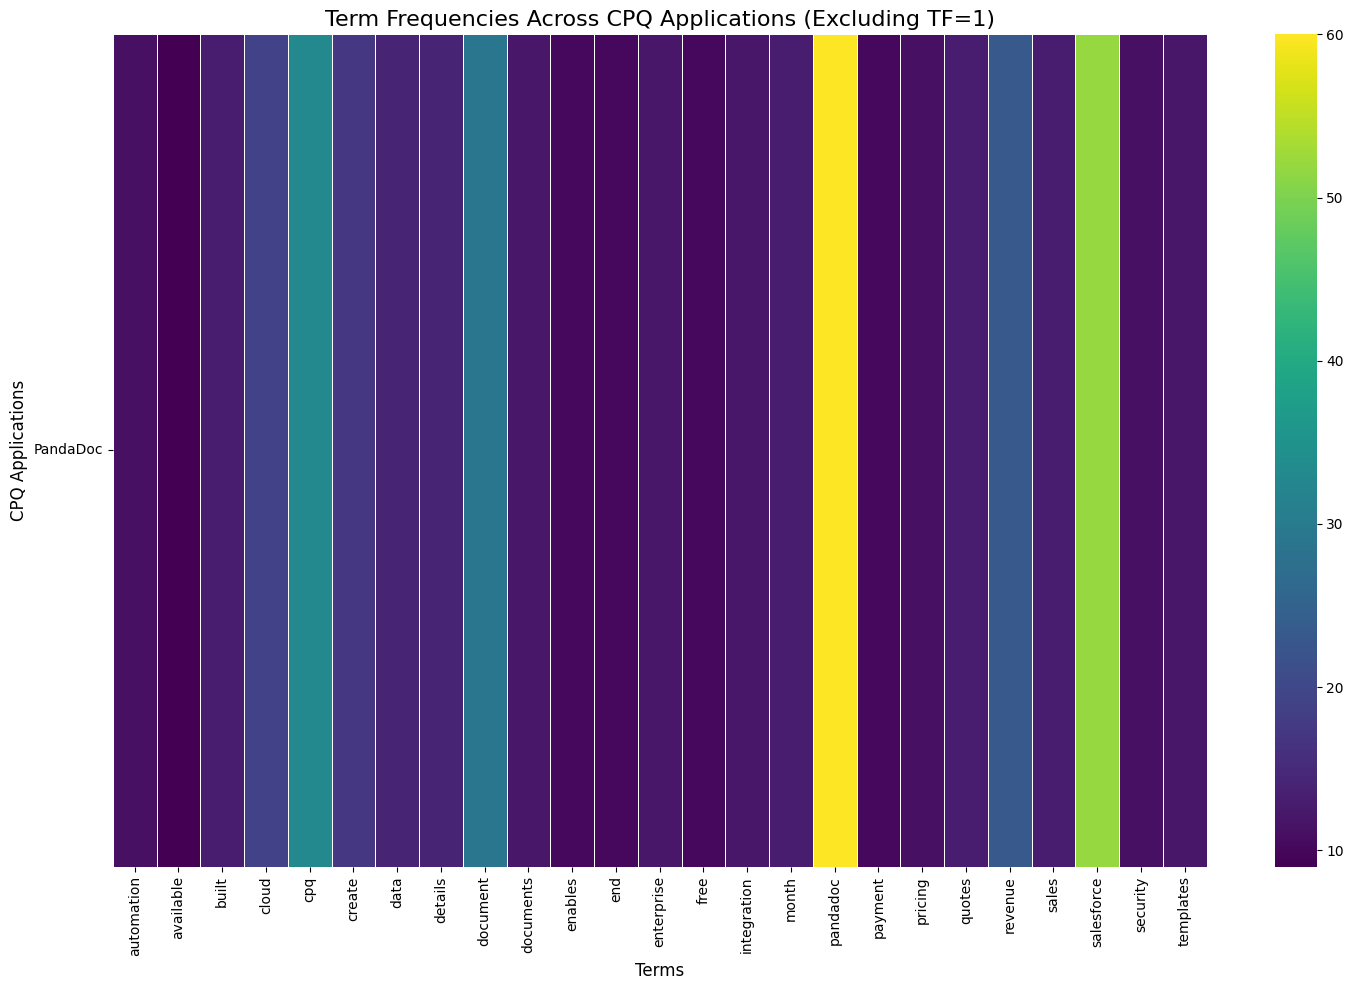

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size
plt.figure(figsize=(15, 10))

# Create a heatmap
sns.heatmap(df_pivot, cmap='viridis', annot=False, fmt='.0f', linewidths=.5)

plt.title('Term Frequencies Across CPQ Applications (Excluding TF=1)', fontsize=16)
plt.xlabel('Terms', fontsize=12)
plt.ylabel('CPQ Applications', fontsize=12)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()